# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math
from tqdm import tqdm

from PIL import Image
import os
import copy
from imagecorruptions import corrupt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
os.chdir("..") #navigate to where safeml is

In [4]:
from DistanceMetricsVec import CVM_Dist_PVal as CVM_p
from DistanceMetricsVec import Anderson_Darling_Dist_PVal as AD_p
from DistanceMetricsVec import Kolmogorov_Smirnov_Dist_PVal as KS_p
from DistanceMetricsVec import Wasserstein_Dist_PVal as WS_p
from DistanceMetricsVec import DTS_Dist_PVal as DTS_p
from DistanceMetricsVec import ES_Dist

In [6]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 32 #import as 32x32 minimum size required by corrpution
width = 32
channels = 3

n_inputs = height * width*channels

ClassFolders = os.listdir("Final_Training/Images")
classes = len(ClassFolders)

for idx, fileName in enumerate(ClassFolders) :
    path = os.path.join("Final_Training/Images", fileName)
    #path = "C:/cmder/Python_Tests/GTSRB/Train/{0}/".format(i)
    print(path)
    classImges = os.listdir(path)
    for img in classImges:
        try:
            image=cv2.imread(os.path.join(path, img))
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(idx)
        except AttributeError:
            print(os.path.join(path, img) + " is not an image")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

Final_Training/Images\00001
Final_Training/Images\00001\GT-00001.csv is not an image
Final_Training/Images\00002
Final_Training/Images\00002\GT-00002.csv is not an image
Final_Training/Images\00003
Final_Training/Images\00003\GT-00003.csv is not an image
Final_Training/Images\00004
Final_Training/Images\00004\GT-00004.csv is not an image
Final_Training/Images\00005
Final_Training/Images\00005\GT-00005.csv is not an image
Final_Training/Images\00006
Final_Training/Images\00006\GT-00006.csv is not an image
Final_Training/Images\00007
Final_Training/Images\00007\GT-00007.csv is not an image
Final_Training/Images\00008
Final_Training/Images\00008\GT-00008.csv is not an image
Final_Training/Images\00009
Final_Training/Images\00009\GT-00009.csv is not an image
Final_Training/Images\00010
Final_Training/Images\00010\GT-00010.csv is not an image
Final_Training/Images\00011
Final_Training/Images\00011\GT-00011.csv is not an image
Final_Training/Images\00012
Final_Training/Images\00012\GT-00012.

# Modelling

## Data prep
This X_test_init file is needed to apply corrution to the raw image before normalizing it in an array.

In [7]:
X_train_init, X_val_init, y_train_init, y_val_init = train_test_split(Cells, labels, test_size=0.40, random_state=42, stratify=labels)
X_val_init, X_test_init, y_val_init, y_test_init = train_test_split(X_val_init, y_val_init, test_size=0.7, random_state=42, stratify=y_val_init)


In [8]:
X_train = X_train_init.astype('float32')/255 
X_val = X_val_init.astype('float32')/255
X_test = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

In [9]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train_init.shape, y_val_init.shape, y_test_init.shape)

(22555, 32, 32, 3) (4511, 32, 32, 3) (10526, 32, 32, 3)
(22555,) (4511,) (10526,)


In [10]:
#select a random 50% fo the test data indecies to be corrupted
corruption_id = np.random.choice(X_test.shape[0], size = math.ceil(0.5 *X_test.shape[0]), replace=False)

# in percentages, 0-75 frost, 25-100 fog with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['motion_blur', 'defocus_blur']
X_test_corrupted = copy.deepcopy(X_test) #copy to override

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_test_corrupted[i,:] = image.astype('float32')/255 #normalize
            

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.76s/it]


In [11]:
#split into calibration and evaluation
X_cal, X_eval, y_cal_init, y_eval_init = train_test_split(X_test_corrupted, y_test_init, test_size=0.5, random_state=42, stratify=y_test_init)


In [12]:
y_train = keras.utils.to_categorical(y_train_init, classes)
y_val = keras.utils.to_categorical(y_val_init, classes)
y_cal = keras.utils.to_categorical(y_cal_init, classes)
y_eval = keras.utils.to_categorical(y_eval_init, classes)

In [13]:
print(X_train.shape, X_val.shape, X_cal.shape)
print(y_train.shape, y_val.shape, y_cal.shape)

(22555, 32, 32, 3) (4511, 32, 32, 3) (5263, 32, 32, 3)
(22555, 42) (4511, 42) (5263, 42)


## Create Model

In [14]:
def build_model(input_shape, num_features, num_labels):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(num_features, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))

    return model

def compile_model(model, lr, loss='categorical_crossentropy', optimizer='adam', acc_metric = "accuracy"):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
    model.compile(loss=loss, optimizer=optimizer, metrics=[acc_metric])
    
    return model

In [15]:
lr = .001
max_epochs = 50
patience = 10
batch_size = 128
input_shape =X_train.shape[1:]
num_features = 100
num_labels = classes

In [16]:
model = build_model(input_shape, num_features, num_labels)
model = compile_model(model, lr)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)                    
history = model.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            shuffle=False, callbacks=[callback])

Epoch 1/50
177/177 [==============================] - 20s 108ms/step - loss: 2.1594 - accuracy: 0.4052 - val_loss: 0.5403 - val_accuracy: 0.8572
Epoch 2/50
177/177 [==============================] - 19s 108ms/step - loss: 0.5355 - accuracy: 0.8315 - val_loss: 0.1818 - val_accuracy: 0.9563
Epoch 3/50
177/177 [==============================] - 19s 107ms/step - loss: 0.2619 - accuracy: 0.9171 - val_loss: 0.0885 - val_accuracy: 0.9800
Epoch 4/50
177/177 [==============================] - 19s 108ms/step - loss: 0.1780 - accuracy: 0.9456 - val_loss: 0.0651 - val_accuracy: 0.9871
Epoch 5/50
177/177 [==============================] - 19s 106ms/step - loss: 0.1295 - accuracy: 0.9605 - val_loss: 0.0484 - val_accuracy: 0.9874
Epoch 6/50
177/177 [==============================] - 19s 107ms/step - loss: 0.1022 - accuracy: 0.9676 - val_loss: 0.0466 - val_accuracy: 0.9902
Epoch 7/50
177/177 [==============================] - 19s 106ms/step - loss: 0.0827 - accuracy: 0.9747 - val_loss: 0.0370 - val_ac

In [18]:
accr = model.evaluate(X_cal, y_cal)
print(accr)

165/165 [==============================] - 1s 8ms/step - loss: 1.4073 - accuracy: 0.6396
[1.407315731048584, 0.6395592093467712]


In [ ]:
import pickle

save = (X_cal, X_eval, y_cal, y_eval)
with open('model.pkl', 'wb') as file:
      
    pickle.dump(model, file)
    
with open('EvalCal_iter1.pkl', 'wb') as file:
      
    pickle.dump(save, file)

In [ ]:
import pickle

with open('DesignCalEval_FF.pkl', 'rb') as file:
      
    model, X_cal, X_eval, y_cal, y_eval = pickle.load(file)

# SafeML Estimators

## Separation and Transforamtion

In [19]:
y_pred = np.argmax(model.predict(X_cal), 1)
y_real = np.argmax(y_cal, 1)

165/165 [==============================] - 1s 8ms/step


In [20]:
#Create mask for incorrect data
mask = np.zeros(len(y_pred))
for idx, yp in enumerate(y_pred):
    mask[idx] = yp == y_real[idx]
    
print(mask)

[1. 0. 1. ... 1. 0. 1.]


In [21]:
print(len(mask) - mask.sum() ) # Number of incorrect examples

1897.0


In [22]:
#Filter to extract the features from last layer

def create_filter(model):
    
    x = model.layers[-2].output
    output = Model(inputs = model.input, outputs= x)
    
    return output

filter_model = create_filter(model)

In [23]:
filtered_train = filter_model.predict(X_train)
filtered_cal = filter_model.predict(X_cal)
filtered_eval = filter_model.predict(X_eval)

165/165 [==============================] - 1s 8ms/step


In [24]:
#Create PCA components to reduce computation
pca = PCA(n_components=15)
train_components = pca.fit_transform(filtered_train)
print(pca.explained_variance_)

[564.5706   362.37387  257.2488   213.54616  196.33272  161.00694
 129.66696  100.92045   84.35019   73.57841   60.064777  55.23697
  39.069485  35.05122   31.049055]


In [25]:
explained = pca.explained_variance_ratio_
explained = [sum(explained[:x]) for x in range(1,len(explained))]
print(explained)

[0.21936103701591492, 0.3601595610380173, 0.4601122736930847, 0.5430845469236374, 0.6193686276674271, 0.6819270551204681, 0.732308492064476, 0.7715206183493137, 0.8042944557964802, 0.8328829705715179, 0.8562208339571953, 0.8776828777045012, 0.8928631274029613, 0.9064821004867554]


Text(0.5, 0, 'component number')

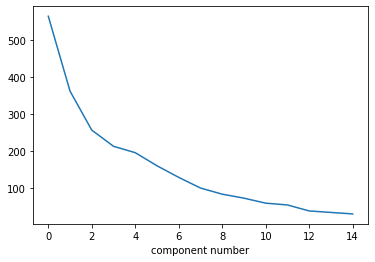

In [26]:
fig, ax1 = plt.subplots()
plt.plot(pca.explained_variance_)


plt.xlabel('component number')

The figure shows to elbow points, at 6 correspondint to 68% explained variance and at 12 for 85% explained variance ration
12 was chosen


In [27]:
cal_components = pca.transform(filtered_cal)

## Create Set of Batches

In [28]:
cal_correct = cal_components[mask == 1, :12]
cal_incorrect = cal_components[mask ==0, :12]

print(cal_correct.shape, cal_incorrect.shape)

(3366, 12) (1897, 12)


In [29]:
def design_windowed_series(data_input, required_samples, instance_num):
    correct, incorrect = data_input
    
    _out = np.zeros((instance_num, required_samples, correct.shape[1]))
    _acc = np.zeros(instance_num)
    rng = np.random.default_rng()
    for idx, x in enumerate(np.linspace(0, required_samples, instance_num)):
        samples = math.ceil(x)
        _acc[idx] = 1 - (samples / required_samples) #decrease accuracy over time
        incorrect_id = np.random.choice(incorrect.shape[0], samples)
        correct_id = np.random.choice(correct.shape[0], required_samples - samples)
        
        _out[idx] = (np.concatenate((incorrect[incorrect_id, :], correct[correct_id, :]), axis = 0))
        rng.shuffle(_out[idx], axis = 0)
        
    return _out, _acc

In [30]:
required_samples = 50
designed_series, accuracy = design_windowed_series((cal_correct, cal_incorrect), required_samples, 1500)


In [31]:
#The designed set contians 1500 batches, each with 50 samples, each of 12 pca components of the image.
#the accuracy of those 50 samples is decreasing.
designed_series.shape

(1500, 50, 12)

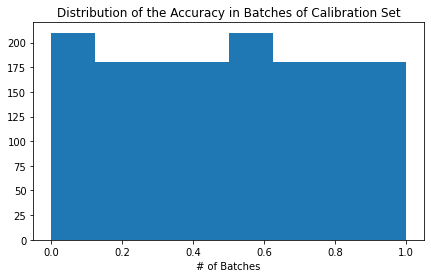

In [32]:
plt.figure(figsize=[7,4])
plt.hist(accuracy, bins=8)
plt.title("Distribution of the Accuracy in Batches of Calibration Set")
plt.xlabel("Accuracy")
plt.xlabel("# of Batches")
plt.show()

## SafeML Implementation

In [60]:
def get_statistical_distance_gpu(train_set, test_set):
    #return statistical distance measures
    if (train_set.shape[1] != test_set.shape[1]):
        print(f"input features are not compatible. input one size {train_set.shape[1]} does not match input two size {test_set.shape[1]}")
        return None
    else:
        input_features = train_set.shape[1]
        
    input_features = train_set.shape[1]
    

    ss_CVM_distances = np.zeros(input_features)
    ss_Anderson_Darling_distances = np.zeros(input_features)
    ss_Kolmogorov_Smirnov_distances = np.zeros(input_features)
    ss_Wasserstein_distances = np.zeros(input_features)
    ss_DTS_distances = np.zeros(input_features)
    es_distances = np.zeros(input_features)
    for i in range(input_features):
        
        pVal_cvm, cvm_res = CVM_p(train_set[:, i], test_set[:, i])
        ss_CVM_distances[i] = cvm_res if (pVal_cvm < 0.05) else np.nan

        
        pVal_ad, ad_res = AD_p(train_set[:, i], test_set[:, i])
        ss_Anderson_Darling_distances[i] = ad_res if (pVal_ad < 0.05) else np.nan
        
        
        pVal_ks, ks_res = KS_p(train_set[:, i], test_set[:, i])
        ss_Kolmogorov_Smirnov_distances[i] = ks_res if (pVal_ks < 0.05) else np.nan
        
        
        pVal_ws, ws_res = WS_p(train_set[:, i], test_set[:, i])
        ss_Wasserstein_distances[i] = ws_res if (pVal_ws < 0.05) else np.nan

        
        pVal_dts, dts_res = DTS_p(train_set[:, i], test_set[:, i])
        ss_DTS_distances[i] = dts_res if (pVal_dts < 0.05) else np.nan
        
        #es_distances[i], _ = ES_Dist(train_set[:, i], test_set[:, i])
    
    CVM_distance = (np.nanmean(ss_CVM_distances, dtype=np.float64), 
                    np.nanstd(ss_CVM_distances, dtype=np.float64))
    Anderson_Darling_distance = (np.nanmean(ss_Anderson_Darling_distances, dtype=np.float64),
                                 np.nanstd(ss_Anderson_Darling_distances, dtype=np.float64))
    Kolmogorov_Smirnov_distance = (np.nanmean(ss_Kolmogorov_Smirnov_distances, dtype=np.float64),
                                   np.nanstd(ss_Kolmogorov_Smirnov_distances, dtype=np.float64))
    Wasserstein_distance = (np.nanmean(ss_Wasserstein_distances, dtype=np.float64),
                            np.nanstd(ss_Wasserstein_distances, dtype=np.float64))
    
    dts_distance = (np.nanmean(ss_DTS_distances, dtype=np.float64),
                            np.nanstd(ss_DTS_distances, dtype=np.float64))
    
    es_distance = (np.mean(es_distances, dtype=np.float64),
                            np.std(es_distances, dtype=np.float64))
    

    
    return {
            'CVM_dist': CVM_distance,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Wasserstein_dist': Wasserstein_distance,
            'DTS_dist' : dts_distance,
            "ES_dist"  : es_distance
           }

In [34]:
def distance_list(input_series, train_ref, acc_list):
    N = len(acc_list)
    
    cvm = np.zeros(N)
    ad = np.zeros(N)
    ks = np.zeros(N)
    ws = np.zeros(N)
    dts = np.zeros(N)
    es = np.zeros(N)
    
    for i in tqdm(range(N)):
        dist = get_statistical_distance_gpu(train_ref, input_series[i, :, :])
        
        cvm[i] = dist['CVM_dist'][0]
        ad[i] = dist['Anderson_Darling_dist'][0]
        ks[i] = dist['Kolmogorov_Smirnov_dist'][0]
        ws[i] = dist['Wasserstein_dist'][0]
        dts[i] = dist['DTS_dist'][0]
        es[i] = dist['ES_dist'][0]
        
    return (cvm, ad, ks, ws, dts, es)

In [35]:
#prepare a training sample scope
idx_train = np.random.choice(filtered_train.shape[0], required_samples * 2, replace=False)
train_samples = train_components[idx_train, :12]

train_samples.shape

(100, 12)

The following code snippet takes a while due to number of distances calculated

In [36]:

cvm, ad, ks, ws, dts, es = distance_list(designed_series, train_samples, accuracy)

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:18:02<00:00,  3.12s/it]


In [213]:
train_samples.shape

(100, 12)

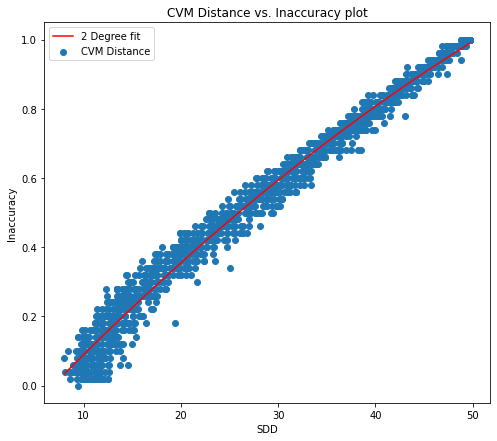

In [221]:
z = np.polyfit(cvm, 1 - accuracy, 2)
x_fit = np.linspace(cvm.min(), cvm.max(), cvm.shape[0])
fit = np.poly1d(z)(x_fit)

plt.figure(figsize=(8,7))

plt.scatter(cvm, 1 - accuracy,  label='CVM Distance')
plt.plot(x_fit, fit, "r")
plt.title('CVM Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "CVM Distance"])


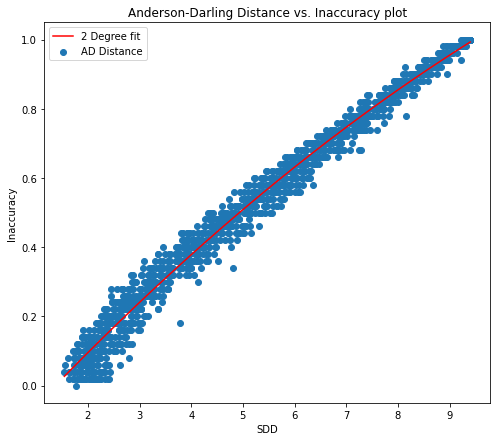

In [223]:
z = np.polyfit(ad, 1 - accuracy, 2)
x_fit = np.linspace(ad.min(), ad.max(), ad.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(ad, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Anderson-Darling Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "AD Distance"])


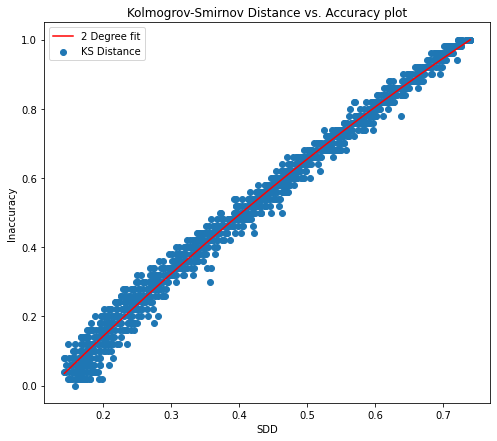

In [224]:
z = np.polyfit(ks, 1 - accuracy, 2)
x_fit = np.linspace(ks.min(), ks.max(), ks.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(ks, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Kolmogrov-Smirnov Distance vs. Accuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "KS Distance"])

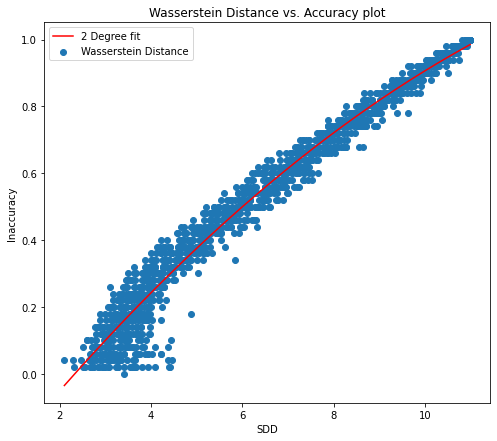

In [225]:
z = np.polyfit(ws, 1 - accuracy, 2)
x_fit = np.linspace(ws.min(), ws.max(), ws.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(ws, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('Wasserstein Distance vs. Accuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "Wasserstein Distance"])

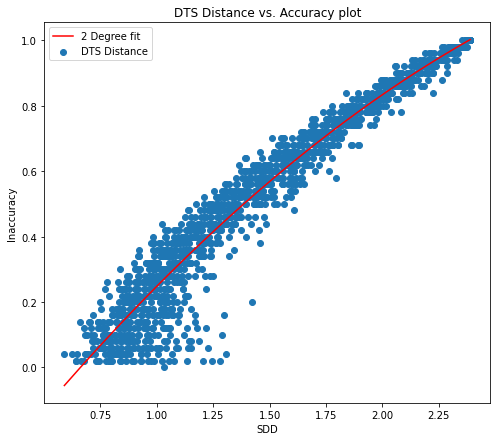

In [226]:
z = np.polyfit(dts, 1 - accuracy, 2)
x_fit = np.linspace(dts.min(), dts.max(), dts.shape[0])
fit = np.poly1d(z)(x_fit)


plt.figure(figsize=(8,7))
plt.scatter(dts, 1 - accuracy, label='Anderson-Darling Distance')
plt.plot(x_fit, fit, "r")
plt.title('DTS Distance vs. Accuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["2 Degree fit", "DTS Distance"])

Parameters: [ 0.21208077 -1.88193336 -0.19169645]
RMSE: 0.4880764593291257
R-squared: 0.7469607811941898


<ipython-input-227-9231d641ffbb>:4: RuntimeWarning: invalid value encountered in log
  return a*np.log(x + b)+c


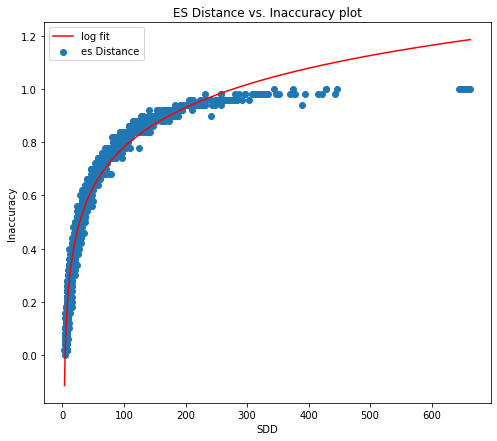

In [227]:
from scipy.optimize import curve_fit

def ln_fun(x, a, b, c): 
        return a*np.log(x + b)+c


x_fit = np.linspace(es.min(), es.max(), es.shape[0])



# these are the same as the scipy defaults
param_init = np.array([1.0, 1.0, 1.0])

# curve fit the test data
param_fit, pcov = curve_fit(ln_fun, es, (1 - accuracy), param_init)

fit_log = ln_fun(x_fit, *param_fit) 

absError = fit_log - (1 - accuracy)

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(1 - accuracy))

print('Parameters:', param_fit)
print('RMSE:', RMSE)
print('R-squared:', Rsquared)


plt.figure(figsize=(8,7))
plt.scatter(es, 1 - accuracy,  label='ES Distance')
plt.plot(x_fit, fit_log, "r")
plt.title('ES Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')
plt.legend(["log fit", "es Distance"])


In [62]:
import pickle

save = (cvm, ad, ks, ws, dts, es, accuracy)
with open('iter1_dist.pkl', 'wb') as file:
      
    pickle.dump(save, file)

# Evaluation

## Data batching
a moving window will go over the evalaution set to create a similar series of batches

In [37]:
def create_windowed_series(data_input, required_samples_threshold, window_overlap): 

    n_features = data_input.shape[1:]
    stride = math.ceil(required_samples * (1 - window_overlap))
    n_series = (math.floor((len(data_input) - required_samples)/stride) + 1)
    
    windowed_data = np.zeros((n_series,
                              required_samples) +
                              n_features)
                             

    for idx in range(n_series):
        windowed_data[idx] = data_input[(idx*stride): (idx*stride) +  required_samples_threshold]


    return windowed_data


In [38]:
window_overlap = 0.8

windowed_series = create_windowed_series(X_eval , required_samples, window_overlap)
windowed_eval = create_windowed_series(np.argmax(y_eval, 1).reshape(-1, 1), required_samples, window_overlap) #reshape groundtruth

## Weight and Measure distance

In [39]:
# transformer from 50x32x32x3 to 50x12
def data_transform(data, model_filter = filter_model, pca = pca, comp = 12):
    
    filtered = model_filter.predict(data)
    components = pca.transform(filtered)
    
    return components[:,:comp]

In [61]:
def get_dist(data_input, train_ref):
    dist = get_statistical_distance_gpu(train_ref, data_input)
        
    cvm = dist['CVM_dist'][0]
    ad = dist['Anderson_Darling_dist'][0]
    ks = dist['Kolmogorov_Smirnov_dist'][0]
    ws = dist['Wasserstein_dist'][0]
    dts = dist['DTS_dist'][0]
    es = dist['DTS_dist'][0]
    
    return np.array([cvm, ad, ks, ws, dts, es])

In [62]:
def get_es(train_set, test_set):
        if (train_set.shape[1] != test_set.shape[1]):
            print(f"input features are not compatible. input one size {train_set.shape[1]} does not match input two size {test_set.shape[1]}")
            return None
        else:
            input_features = train_set.shape[1]

        input_features = train_set.shape[1]

        w2 = np.zeros(input_features)
        p_val = np.zeros(input_features)


        for i in range(input_features):

            w2[i], _ = ES_Dist(train_set[:, i], test_set[:, i])
            
        return w2.mean()

In [63]:
#Use vanilla cost function of +10, -20
def vanilla_eval(data_input, eval_data, model, train_ref = train_samples):
    weights = np.zeros(data_input.shape[0])
    distances = np.zeros((data_input.shape[0], 6))
    acc = np.zeros(data_input.shape[0])
    
    for idx, batch in enumerate(data_input):
        
        trans_data = data_transform(batch) 
        pred_out = np.argmax(model.predict(batch), 1).reshape(-1, 1) # This step can be done before batching to make process faster
        weights[idx] = np.sum((pred_out == eval_data[idx])*3 -2)*10 # when true (1*3 - 2)*10, when false (0*3 - 2)*10 => +10/-20
        distances[idx, :] = get_dist(trans_data, train_ref)
        acc[idx] = np.sum((pred_out == eval_data[idx]))/len(batch)
        
    return (weights, distances, acc)
         

In [ ]:
weights, distances, eval_acc = vanilla_eval(windowed_series, windowed_eval, model)

In [70]:
import pickle

save = (weights, distances, eval_acc)
with open('iter1_evalCC.pkl', 'wb') as file:
      
    pickle.dump(save, file)

## Build Estimator

In [82]:
def create_estimator_poly(dist_list, acc, degree= 2):
    z = np.polyfit(dist_list, 1 - acc, degree)
    
    def est(dist): #The function should be bound up and down
        if dist > dist_list[-1]:
            return 1
        
        elif dist < dist_list[0]:
            return 0
        
        else:
            return np.poly1d(z)(dist)
        
    return est

def create_estimator_log(es, accuracy):
    
    
    x_fit = np.linspace(es.min(), es.max(), es.shape[0])

    # these are the same as the scipy defaults
    param_init = np.array([1.0, 1.0, 1.0])
    param_fit, _ = curve_fit(ln_fun, es, (1 - accuracy), param_init)


    
    x_fit = np.linspace(es.min(), es.max(), es.shape[0])
    
    below_zero = None
    above_one = None
    for idx, x in enumerate(x_fit):
        if below_zero is None:
            if ln_fun(x, *param_fit) >= 0: below_zero = idx
                
        if above_one is None:
            if ln_fun(x, *param_fit) >= 1: 
                above_one = idx - 1
                break
    
    def est(dist): #The function should be bound up and down

        if dist > x_fit[above_one]:
            return 1
        
        elif dist < x_fit[below_zero]:
            return 0
        
        else:
            return ln_fun(dist, *param_fit)
        
    return est

In [83]:
print(f"Min accuracy in the barches: {eval_acc.min()}\nMax accuracy in the batches: {eval_acc.max()}")

Min accuracy in the barches: 0.44
Max accuracy in the batches: 0.82


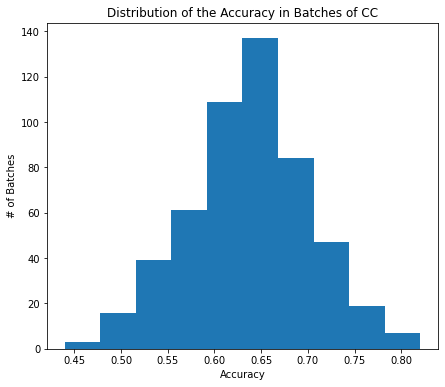

Min accuracy in the barches: 0.44
Max accuracy in the batches: 0.82


In [70]:
plt.figure(figsize=[7,6])
plt.hist(eval_acc)
plt.title("Distribution of the Accuracy in Batches of CC")
plt.xlabel("Accuracy")
plt.ylabel("# of Batches")
plt.show()

print(f"Min accuracy in the barches: {eval_acc.min()}\nMax accuracy in the batches: {eval_acc.max()}")

In [87]:
print(weights.mean(), weights.sum())

-42.12643678160919 -21990.0


### CVM distance

In [84]:
cvm_estimator = create_estimator_poly(cvm, accuracy)

In [85]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances):
    if cvm_estimator(dist[0]) < uncer_thresh:
        total_weight += weights[idx]
        
mean_weight = total_weight / len(weights)

In [86]:
print(mean_weight, total_weight)

-36.877394636015325 -19250.0


Obvios decrease in weight

In [88]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if cvm_estimator(dist[0]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [89]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 10
within the accuracy range: 0.44 0.54


Text(0.5, 0, 'SDD')

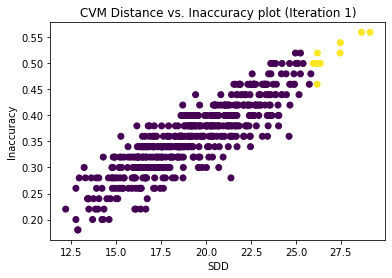

In [90]:
plt.figure()
plt.scatter(distances[:, 0], 1- eval_acc,  c=c_mask)
plt.title('CVM Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')



In [91]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if cvm_estimator(dist[0]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

9 510 1 2


#### SafeML Threshold CVM (IMBSA)

In [83]:
tt_weight = 0
dist_thresh = 26.31
rej = 0

for idx, dist in enumerate(distances):
    if dist[0] < dist_thresh:
        tt_weight += weights[idx]
            
    else:
        rej += 1
        
tm_weight = tt_weight / len(weights)

In [84]:
print(tm_weight, tt_weight)

-37.81609195402299 -19740.0


No cost reduction.     
Using the Threshold from IMBSA (31.6) yields the same result

## Anderson Darling

In [93]:
ad_estimator = create_estimator_poly(ad, accuracy)

In [94]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if ad_estimator(dist[1]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [95]:
print(mean_weight, total_weight)

-36.99233716475096 -19310.0


In [96]:
rejected = []
c_mask = np.zeros(len(distances))

for idx, dist in enumerate(distances):
    if ad_estimator(dist[1]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [97]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

10
0.44 0.54


Text(0.5, 0, 'SDD')

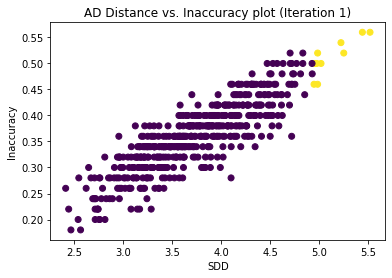

In [98]:
plt.figure()
plt.scatter(distances[:, 1],1-eval_acc,  c=c_mask)
plt.title('AD Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')



In [99]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if ad_estimator(dist[1]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

8 510 2 2


#### SafeML Threshold AD (IMBSA)

In [155]:
tt_weight = 0
dist_thresh = 4.9
rej = 0
for idx, dist in enumerate(distances):
    if dist[1] < dist_thresh:
        tt_weight += weights[idx]
        
    else:
        rej += 1
        
tm_weight = tt_weight / len(weights)

In [156]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-36.015325670498086 -18800.0
Number of rejected Examples:  7


Minimal cost reduction.  
Using the Treshold from IMBSA (4.38) yields a rejection of 3 points with weight of -17830

## Kolmogrov Smirnov

In [102]:
ks_estimator = create_estimator_poly(ks, accuracy)

In [103]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if ks_estimator(dist[2]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [104]:
print(mean_weight, total_weight)

-37.662835249042146 -19660.0


In [105]:
rejected = []
c_mask = np.zeros(len(distances))

for idx, dist in enumerate(distances):
    if ks_estimator(dist[2]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [106]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

8
0.44 0.5


Text(0.5, 0, 'SDD')

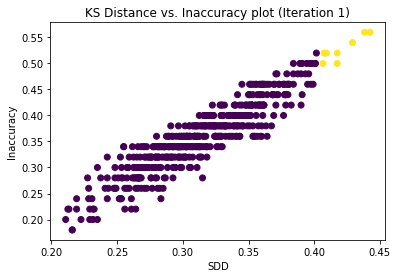

In [107]:
plt.figure()
plt.scatter(distances[:, 2],1-eval_acc,  c=c_mask)
plt.title('KS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')



In [108]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if ks_estimator(dist[2]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

8 513 0 1


#### SafeML Threshold KS (IMBSA)

In [163]:
tt_weight = 0
dist_thresh = 0.5
rej = 0
c_mask2 = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if dist[2] < dist_thresh:
        tt_weight += weights[idx]
        
    else:
        rej += 1
        c_mask2[idx] = 1
        
tm_weight = tt_weight / len(weights)

In [128]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-39.59770114942529 -20670.0
Number of rejected Examples:  0


No Cost reduction using the threshold obtained from corrupted images

The threshold from IMBSA (0.34) performs very well with weight of -3630 and 92 rejected examples     
However, a better performance is achieved by setting the uncertainty to 0.4 instead of 0.5 achieving:    
weight 2700.0 and 158 rejected samples


## Wasserstein

In [109]:
ws_estimator = create_estimator_poly(ws, accuracy)

In [110]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if ws_estimator(dist[3]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [111]:
print(mean_weight, total_weight)

-37.41379310344828 -19530.0


In [112]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if ws_estimator(dist[3]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [113]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

9
0.44 0.56


Text(0.5, 0, 'SDD')

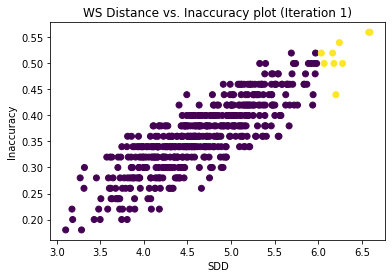

In [114]:
plt.figure()
plt.scatter(distances[:, 3],1-eval_acc,  c=c_mask)
plt.title('WS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')


In [115]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if ws_estimator(dist[3]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

8 511 1 2


#### SafeML Threshold Wasserstein (IMBSA)

In [170]:
tt_weight = 0
dist_thresh = 5.17
rej = 0

for idx, dist in enumerate(distances):
    if dist[3] < dist_thresh:
        tt_weight += weights[idx]
        
    else:
        rej += 1

tm_weight = tt_weight / len(weights)

In [171]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-37.81609195402299 -19740.0
Number of rejected Examples:  3


The threshold from IMBSA (2.928) performs badly as all samples are rejected     
After tuning the threshold for corruption, a good performance can be achieved     
However, a better result can again be achieved by changing the uncertainty thershold to 0.4     
weight 1160.0 and 162 rejected samples

## DTS

In [116]:
dts_estimator = create_estimator_poly(dts, accuracy)

In [117]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if dts_estimator(dist[4]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [118]:
print(mean_weight, total_weight)

-34.310344827586206 -17910.0


In [119]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if dts_estimator(dist[4]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [120]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

24
0.44 0.66


Text(0.5, 0, 'SDD')

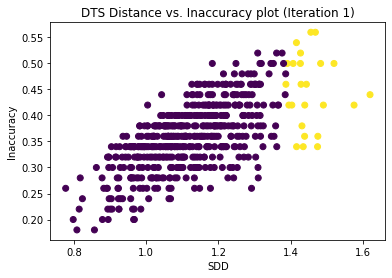

In [121]:
plt.figure()
plt.scatter(distances[:, 4],1-eval_acc,  c=c_mask)
plt.title('DTS Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')


In [122]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if dts_estimator(dist[4]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

9 495 15 3


#### SafeML Threshold DTS (IMBSA)

In [178]:
tt_weight = 0
dist_thresh = 1.499
rej = 0

for idx, dist in enumerate(distances):
    if dist[4] < dist_thresh:
        tt_weight += weights[idx]
        
    else:
        rej += 1

tm_weight = tt_weight / len(weights)

In [179]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-39.59770114942529 -20670.0
Number of rejected Examples:  0


Threshold did not converge and could not be set for IMBSA      
However, by tuning the theshold from the corrputed images a good performance can be reached

### ES-Test

In [124]:
es_estimator = create_estimator_log(es, accuracy)

<ipython-input-81-e1c1ee5681c4>:4: RuntimeWarning: invalid value encountered in log
  return a*np.log(x + b)+c


In [130]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances):
    if es_estimator(dist[5]) < uncer_thresh:
        total_weight += weights[idx]
        
        
mean_weight = total_weight / len(weights)

In [131]:
print(mean_weight, total_weight)

-37.83524904214559 -19750.0


In [133]:
rejected = []
c_mask = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if es_estimator(dist[5]) > uncer_thresh:
        rejected.append(eval_acc[idx])
        c_mask[idx] = 1

In [134]:
print(len(rejected))
print(np.array(rejected).min(), np.array(rejected).max())

8
0.44 0.52


Text(0.5, 0, 'SDD')

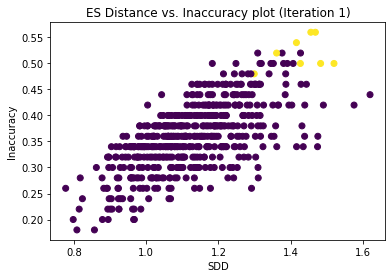

In [135]:
plt.figure()
plt.scatter(distances[:, 5],1-eval_acc,  c=c_mask)
plt.title('ES Distance vs. Inaccuracy plot (Iteration 1)')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')


In [136]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances):
    if es_estimator(dist[5]) > uncer_thresh:
        TP += 1 if (eval_acc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

7 511 1 3


## Completely out of Context Evaluation

In [43]:
X_oc = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

#select a random 50% fo the test data indecies to be corrupted
corruption_id = np.random.choice(X_oc.shape[0], size = math.ceil(0.5 *X_oc.shape[0]), replace=False)

# in percentages, 0-75 frost, 25-100 fog with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['frost', 'snow']

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_oc[i,:] = image.astype('float32')/255 #normalize
            

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:31<00:00, 15.62s/it]


In [44]:
#split into calibration and evaluation
_, X_evalOC, _, y_evalOC_init = train_test_split(X_oc, y_test_init, test_size=0.5, random_state=42, stratify=y_test_init)
y_evalOC = keras.utils.to_categorical(y_evalOC_init, classes)

In [45]:
accr = model.evaluate(X_evalOC, y_evalOC)
print(accr)

165/165 [==============================] - 1s 8ms/step - loss: 1.2981 - accuracy: 0.6597
[1.2981399297714233, 0.6596997976303101]


In [46]:
def create_windowed_series(data_input, required_samples_threshold, window_overlap): 

    n_features = data_input.shape[1:]
    stride = math.ceil(required_samples * (1 - window_overlap))
    n_series = (math.floor((len(data_input) - required_samples)/stride) + 1)
    
    windowed_data = np.zeros((n_series,
                              required_samples) +
                              n_features)
                             

    for idx in range(n_series):
        windowed_data[idx] = data_input[(idx*stride): (idx*stride) +  required_samples_threshold]


    return windowed_data


In [47]:

window_overlap = 0.8

windowed_series_oc = create_windowed_series(X_evalOC , required_samples, window_overlap)
windowed_eval_oc = create_windowed_series(np.argmax(y_evalOC, 1).reshape(-1, 1), required_samples, window_overlap) #reshape groundtruth

In [48]:
windowed_series_oc.shape

(522, 50, 32, 32, 3)

In [ ]:
weights_oc, distances_oc, eval_acc_oc = vanilla_eval(windowed_series_oc, windowed_eval_oc, model)

In [506]:

save = (weights_oc, distances_oc, eval_acc_oc)
with open('DesignSemiOutContext.pkl', 'wb') as file:
      
    pickle.dump(save, file)

In [139]:
print(weights_oc.mean(), weights_oc.sum())

-11.264367816091953 -5880.0


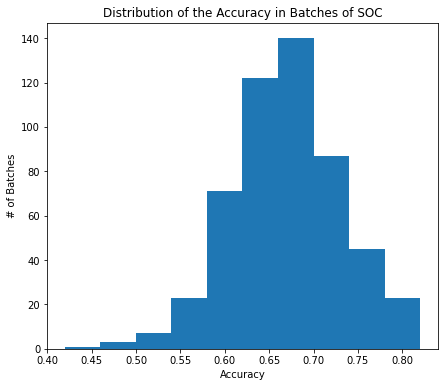

Min accuracy in the barches: 0.44
Max accuracy in the batches: 0.82


In [73]:
plt.figure(figsize=[7,6])
plt.hist(eval_acc_oc)
plt.title("Distribution of the Accuracy in Batches of SOC")
plt.xlabel("Accuracy")
plt.ylabel("# of Batches")
plt.show()

print(f"Min accuracy in the barches: {eval_acc.min()}\nMax accuracy in the batches: {eval_acc.max()}")


### CVM distance

In [137]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc):
    if cvm_estimator(dist[0]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
mean_weight = total_weight / len(weights_oc)

In [138]:
print(mean_weight, total_weight)

-6.934865900383142 -3620.0


In [140]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if cvm_estimator(dist[0]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [141]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 10
within the accuracy range: 0.42 0.6


Text(0.5, 0, 'CVM distance')

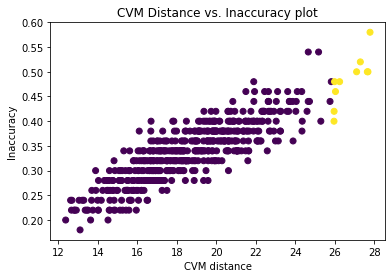

In [142]:
plt.figure()
plt.scatter(distances_oc[:, 0], 1- eval_acc_oc,  c=c_mask)
plt.title('CVM Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('CVM distance')

In [151]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if cvm_estimator(dist[0]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

5 510 5 2


#### SafeML Threshold CVM (IMBSA) 

In [143]:
tt_weight = 0
dist_thresh = 31.6
rej = 0

for idx, dist in enumerate(distances_oc):
    if dist[0] < dist_thresh:
        tt_weight += weights_oc[idx]
            
    else:
        rej += 1
        
tm_weight = tt_weight / len(weights)

In [423]:
print(tm_weight, tt_weight)

-15.681470137825421 -10240.0


No reduction

### Anderson Darling distance

In [145]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if ad_estimator(dist[1]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [146]:
print(mean_weight, total_weight)

-7.739463601532567 -4040.0


In [147]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if ad_estimator(dist[1]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [148]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 7
within the accuracy range: 0.42 0.52


Text(0.5, 0, 'AD distance')

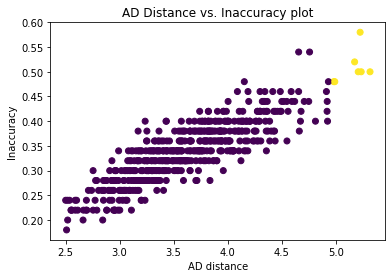

In [149]:
plt.figure()
plt.scatter(distances_oc[:, 1], 1- eval_acc_oc,  c=c_mask)
plt.title('AD Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('AD distance')

In [152]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if ad_estimator(dist[1]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

5 513 2 2


#### SafeML Threshold AD (IMBSA)

In [430]:
tt_weight = 0
dist_thresh = 4.38
rej = 0
for idx, dist in enumerate(distances_oc):
    if dist[1] < dist_thresh:
        tt_weight += weights_oc[idx]
        
    else:
        rej += 1
        
tm_weight = tt_weight / len(weights_oc)

In [433]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-14.716692189892802 -9610.0
Number of rejected Examples:  3


Minimal reduction, just outliers

### Kolmogrov Smirnov

In [153]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if ks_estimator(dist[2]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [154]:
print(mean_weight, total_weight)

-7.088122605363985 -3700.0


In [155]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if ks_estimator(dist[2]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [156]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 8
within the accuracy range: 0.42 0.54


Text(0.5, 0, 'KS distance')

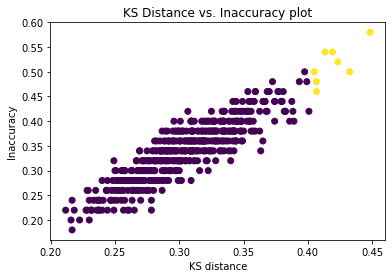

In [157]:
plt.figure()
plt.scatter(distances_oc[:, 2], 1- eval_acc_oc,  c=c_mask)
plt.title('KS Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('KS distance')

In [158]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if ks_estimator(dist[2]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

6 514 2 0


#### SafeML Threshold KS (IMBSA)

In [822]:
tt_weight = 0
dist_thresh = 0.3466
rej = 0
c_mask2 = np.zeros(len(distances))
for idx, dist in enumerate(distances):
    if dist[2] < dist_thresh:
        tt_weight += weights[idx]
        
    else:
        rej += 1
        c_mask2[idx] = 1
        
tm_weight = tt_weight / len(weights)

In [823]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-8.208269525267994 -5360.0
Number of rejected Examples:  79


Text(0.5, 0, 'KS distance')

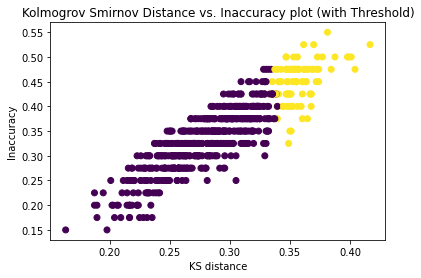

In [446]:

plt.figure()
plt.scatter(distances_oc[:, 2],1-eval_acc_oc,  c=c_mask2)
plt.title('Kolmogrov Smirnov Distance vs. Inaccuracy plot (with Threshold)')
plt.ylabel('Inaccuracy')
plt.xlabel('KS distance')



### Wasserstein 

In [159]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if ws_estimator(dist[3]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [160]:
print(mean_weight, total_weight)

-8.160919540229886 -4260.0


In [161]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if ws_estimator(dist[3]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [162]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 6
within the accuracy range: 0.42 0.52


Text(0.5, 0, 'CVM distance')

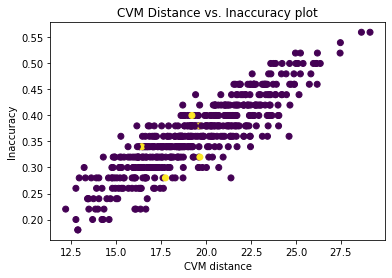

In [163]:
plt.figure()
plt.scatter(distances[:, 0], 1- eval_acc,  c=c_mask)
plt.title('CVM Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('CVM distance')

In [164]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if ws_estimator(dist[3]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

5 514 1 2


#### SafeML Threshold WS (IMBSA)

In [454]:
tt_weight = 0
dist_thresh = 2.067
rej = 0
for idx, dist in enumerate(distances_oc):
    if dist[3] < dist_thresh:
        tt_weight += weights_oc[idx]
        
    else:
        rej += 1
        
tm_weight = tt_weight / len(weights_oc)

In [455]:
print(tm_weight, tt_weight)

0.0 0


### DTS

In [165]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc):
    if dts_estimator(dist[4]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
        
mean_weight = total_weight / len(weights_oc)

In [166]:
print(mean_weight, total_weight)

-8.218390804597702 -4290.0


In [167]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if dts_estimator(dist[4]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [168]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 12
within the accuracy range: 0.48 0.66


Text(0.5, 0, 'DTS distance')

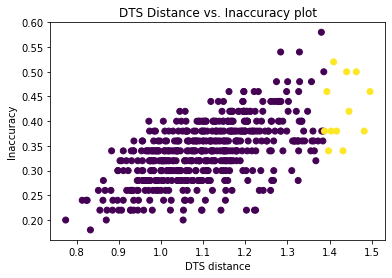

In [169]:
plt.figure()
plt.scatter(distances_oc[:, 4], 1- eval_acc_oc,  c=c_mask)
plt.title('DTS Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('DTS distance')

In [170]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if dts_estimator(dist[4]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

3 507 9 3


### ES Test

In [175]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc):

    if es_estimator(dist[5]) < uncer_thresh:
        total_weight += weights_oc[idx]
        
mean_weight = total_weight / len(weights)

In [176]:
print(mean_weight, total_weight)

-6.590038314176245 -3440.0


In [177]:
rejected = []
c_mask = np.zeros(len(distances_oc))
for idx, dist in enumerate(distances_oc):
    if es_estimator(dist[5]) > uncer_thresh:
        rejected.append(eval_acc_oc[idx])
        c_mask[idx] = 1

In [178]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 10
within the accuracy range: 0.42 0.6


Text(0.5, 0, 'SDD')

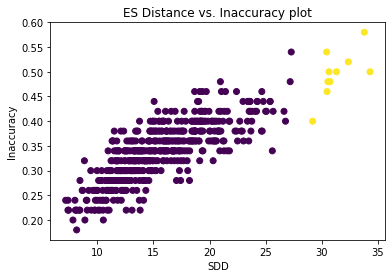

In [179]:
plt.figure()
plt.scatter(distances_oc[:, 5], 1- eval_acc_oc,  c=c_mask)
plt.title('ES Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('SDD')

In [180]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc):
    if es_estimator(dist[5]) > uncer_thresh:
        TP += 1 if (eval_acc_oc[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

6 511 4 1


### Semi Out of Context Corruption

In [52]:
X_oc2 = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

#select a random 50% of the test data indecies to be corrupted
corruption_id = np.random.choice(X_oc2.shape[0], size = math.ceil(0.5 *X_oc2.shape[0]), replace=False)

# in percentages, 0-75 defocus_blur, 25-100 motion_blur with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['shot_noise', 'motion_blur']

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_oc2[i,:] = image.astype('float32')/255 #normalize

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.07s/it]


In [53]:
#split into calibration and evaluation
_, X_evalOC2, _, y_evalOC_init = train_test_split(X_oc2, y_test_init, test_size=0.5, random_state=42, stratify=y_test_init)
y_evalOC = keras.utils.to_categorical(y_evalOC_init, classes)

In [54]:
accr = model.evaluate(X_evalOC2, y_evalOC)
print(accr)


165/165 [==============================] - 2s 11ms/step - loss: 1.3988 - accuracy: 0.6426
[1.3988418579101562, 0.6425992846488953]


In [55]:
def create_windowed_series(data_input, required_samples_threshold, window_overlap): 

    n_features = data_input.shape[1:]
    stride = math.ceil(required_samples * (1 - window_overlap))
    n_series = (math.floor((len(data_input) - required_samples)/stride) + 1)
    
    windowed_data = np.zeros((n_series,
                              required_samples) +
                              n_features)
                             

    for idx in range(n_series):
        windowed_data[idx] = data_input[(idx*stride): (idx*stride) +  required_samples_threshold]


    return windowed_data


In [56]:

window_overlap = 0.8

windowed_series_oc2 = create_windowed_series(X_evalOC2 , required_samples, window_overlap)
windowed_eval_oc2 = create_windowed_series(np.argmax(y_evalOC, 1).reshape(-1, 1), required_samples, window_overlap) #reshape groundtruth

In [ ]:
weights_oc2, distances_oc2, eval_acc_oc2 = vanilla_eval(windowed_series_oc2, windowed_eval_oc2, model)

In [507]:
save = (weights_oc2, distances_oc2, eval_acc_oc2)
with open('DesignCompOutContext.pkl', 'wb') as file:
      
    pickle.dump(save, file)

In [187]:
print(weights_oc2.mean(), weights_oc2.sum())

-34.71264367816092 -18120.0


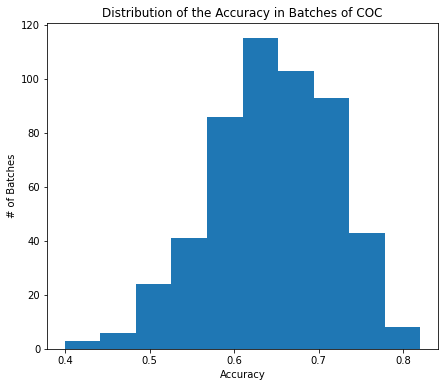

Min accuracy in the barches: 0.44
Max accuracy in the batches: 0.82


In [75]:
plt.figure(figsize=[7,6])
plt.hist(eval_acc_oc2)
plt.title("Distribution of the Accuracy in Batches of COC")
plt.xlabel("Accuracy")
plt.ylabel("# of Batches")
plt.show()

print(f"Min accuracy in the barches: {eval_acc.min()}\nMax accuracy in the batches: {eval_acc.max()}")


In [181]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc2):
    if cvm_estimator(dist[0]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
mean_weight = total_weight / len(weights_oc2)

In [182]:
print(mean_weight, total_weight)

-26.28352490421456 -13720.0


In [183]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if cvm_estimator(dist[0]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [184]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 17
within the accuracy range: 0.4 0.56


Text(0.5, 0, 'CVM distance')

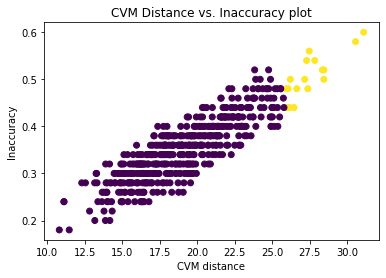

In [185]:
plt.figure()
plt.scatter(distances_oc2[:, 0], 1- eval_acc_oc2,  c=c_mask)
plt.title('CVM Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('CVM distance')

In [193]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if cvm_estimator(dist[0]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

10 503 7 2


#### SafeML threshold CVM out of context (IMBSA)

In [992]:
tt_weight = 0
dist_thresh = 26.31
rej = 0

for idx, dist in enumerate(distances_oc2):
    if dist[0] < dist_thresh:
        tt_weight += weights_oc2[idx]
            
    else:
        rej += 1
        
tm_weight = tt_weight / len(weights_oc2)

In [993]:
print(tm_weight, tt_weight)

-30.704441041347625 -20050.0


No cost reduction.     
Using the Threshold from IMBSA (31.6) yields the same result

### Anderson Darling

In [188]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if ad_estimator(dist[1]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [189]:
print(mean_weight, total_weight)

-26.704980842911876 -13940.0


In [190]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if ad_estimator(dist[1]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [191]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 16
within the accuracy range: 0.4 0.56


Text(0.5, 0, 'AD distance')

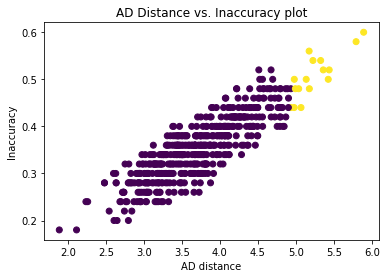

In [192]:
plt.figure()
plt.scatter(distances_oc2[:, 1], 1- eval_acc_oc2,  c=c_mask)
plt.title('AD Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('AD distance')

In [194]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if ad_estimator(dist[1]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

10 504 6 2


#### SafeML Threshold Anderson Darling out of context IMBSA

In [1010]:
tt_weight = 0
dist_thresh = 4.9
rej = 0
c_mask2 = np.zeros(len(distances_oc2))

for idx, dist in enumerate(distances_oc2):
    if dist[1] < dist_thresh:
        tt_weight += weights_oc2[idx]
        
    else:
        rej += 1
        c_mask2[idx] = 1
        
tm_weight = tt_weight / len(weights_oc2)

In [1011]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-29.81623277182236 -19470.0
Number of rejected Examples:  2


Minimal cost reduction.  
Using the Treshold from IMBSA (4.38) yields a rejection of 8 points with weight of -17880.0

Text(0.5, 0, 'AD distance')

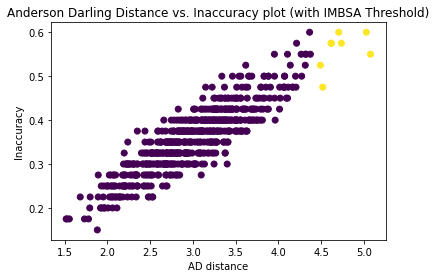

In [1005]:

plt.figure()
plt.scatter(distances_oc2[:, 1],1-eval_acc_oc2,  c=c_mask2)
plt.title('Anderson Darling Distance vs. Inaccuracy plot (with IMBSA Threshold)')
plt.ylabel('Inaccuracy')
plt.xlabel('AD distance')

### Kolmogrov Smirnov

In [195]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if ks_estimator(dist[2]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [196]:
print(mean_weight, total_weight)

-27.1455938697318 -14170.0


In [197]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if ks_estimator(dist[2]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [198]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 14
within the accuracy range: 0.4 0.52


Text(0.5, 0, 'KS distance')

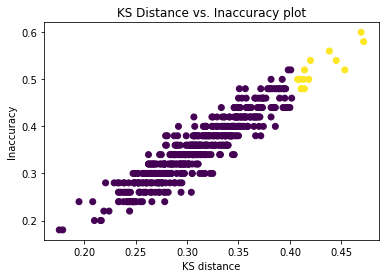

In [199]:
plt.figure()
plt.scatter(distances_oc2[:, 2], 1- eval_acc_oc2,  c=c_mask)
plt.title('KS Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('KS distance')

In [200]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if ks_estimator(dist[2]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

11 506 3 2


#### SafeML Threshold KS out of context IMBSA

In [1020]:
tt_weight = 0
dist_thresh = 0.49
rej = 0
c_mask2 = np.zeros(len(distances_oc2))

for idx, dist in enumerate(distances_oc2):
    if dist[2] < dist_thresh:
        tt_weight += weights_oc2[idx]
        
    else:
        rej += 1
        c_mask2[idx] = 1
        
tm_weight = tt_weight / len(weights_oc2)

In [1021]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-30.704441041347625 -20050.0
Number of rejected Examples:  0


No Cost reduction using the threshold using image corruption      
Using the Treshold from IMBSA (0.346) yields a rejection of 77 points with weight of -6270.0

### Wasserstein

In [201]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if ws_estimator(dist[3]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [202]:
print(mean_weight, total_weight)

-29.291187739463602 -15290.0


In [203]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if ws_estimator(dist[3]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [204]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 10
within the accuracy range: 0.4 0.56


Text(0.5, 0, 'WS distance')

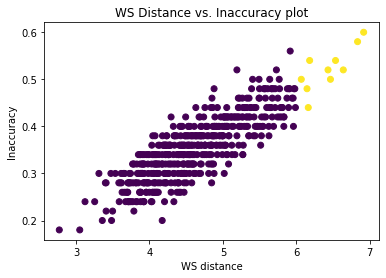

In [205]:
plt.figure()
plt.scatter(distances_oc2[:, 3], 1- eval_acc_oc2,  c=c_mask)
plt.title('WS Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('WS distance')

In [206]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if ws_estimator(dist[3]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

8 509 2 3


#### SafeML Threshold wasserstein out of context IMBSA

In [866]:
tt_weight = 0
dist_thresh = 5.17
rej = 0
c_mask2 = np.zeros(len(distances_oc2))

for idx, dist in enumerate(distances_oc2):
    if dist[3] < dist_thresh:
        tt_weight += weights_oc2[idx]
        
    else:
        rej += 1
        c_mask2[idx] = 1
        
tm_weight = tt_weight / len(weights_oc2)

In [867]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-12.358346094946402 -8070.0
Number of rejected Examples:  71


Good performance with the tuned corrpted image threshold     
Using the threshold from IMBSA yields a result were all points are rejected

### DTS Distance

In [207]:
total_weight = 0
uncer_thresh = 0.5


for idx, dist in enumerate(distances_oc2):
    if dts_estimator(dist[4]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
        
mean_weight = total_weight / len(weights_oc2)

In [208]:
print(mean_weight, total_weight)

-27.06896551724138 -14130.0


In [209]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if dts_estimator(dist[4]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [210]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 21
within the accuracy range: 0.4 0.66


Text(0.5, 0, 'DTS distance')

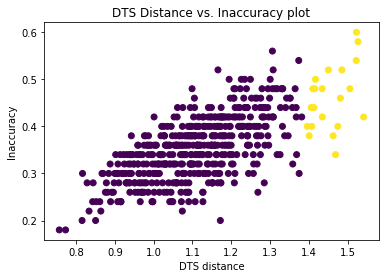

In [211]:
plt.figure()
plt.scatter(distances_oc2[:, 4], 1- eval_acc_oc2,  c=c_mask)
plt.title('DTS Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('DTS distance')

In [212]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if dts_estimator(dist[4]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

6 497 15 4


#### SafeML Comp

In [870]:
tt_weight = 0
dist_thresh = 1.499
rej = 0
c_mask2 = np.zeros(len(distances_oc2))

for idx, dist in enumerate(distances_oc2):
    if dist[4] < dist_thresh:
        tt_weight += weights_oc2[idx]
        
    else:
        rej += 1
        c_mask2[idx] = 1
        
tm_weight = tt_weight / len(weights_oc2)

In [871]:
print(tm_weight, tt_weight)
print("Number of rejected Examples: ", rej)

-11.240428790199081 -7340.0
Number of rejected Examples:  88


### ES Test

In [213]:
total_weight = 0
uncer_thresh = 0.5

for idx, dist in enumerate(distances_oc2):

    if es_estimator(dist[5]) < uncer_thresh:
        total_weight += weights_oc2[idx]
        
mean_weight = total_weight / len(weights)

In [214]:
print(mean_weight, total_weight)

-26.762452107279692 -13970.0


In [215]:
rejected = []
c_mask = np.zeros(len(distances_oc2))
for idx, dist in enumerate(distances_oc2):
    if es_estimator(dist[5]) > uncer_thresh:
        rejected.append(eval_acc_oc2[idx])
        c_mask[idx] = 1

In [216]:
print(f"samples rejected: {len(rejected)}")
print("within the accuracy range:", np.array(rejected).min(), np.array(rejected).max())

samples rejected: 16
within the accuracy range: 0.4 0.6


Text(0.5, 0, 'DTS distance')

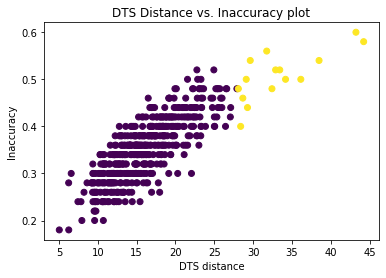

In [217]:
plt.figure()
plt.scatter(distances_oc2[:, 5], 1- eval_acc_oc2,  c=c_mask)
plt.title('DTS Distance vs. Inaccuracy plot')
plt.ylabel('Inaccuracy')
plt.xlabel('DTS distance')

In [218]:
TP, TN, FP, FN = 0, 0, 0, 0

for idx, dist in enumerate(distances_oc2):
    if es_estimator(dist[5]) > uncer_thresh:
        TP += 1 if (eval_acc_oc2[idx] <= 1 - uncer_thresh) else 0
        FP += 1 if (eval_acc_oc2[idx] > 1 - uncer_thresh) else 0
    else:
        TN += 1 if (eval_acc_oc2[idx] >= 1 - uncer_thresh) else 0
        FN += 1 if (eval_acc_oc2[idx] < 1 - uncer_thresh) else 0
print(TP, TN, FP, FN)

10 504 6 2
